Mounted at /content/drive
Indexing word vectors.
Found 400001 word vectors.
16852
     Annotation                                               text
120     neither  PacerNation / on the road Perfect way to conti...
5864  offensive      Bad Asian bitch yea she look just like Kemora
78    offensive           CASHandBOOBIES I been kidnapped yo bitch
3903  offensive  YeridZee bitches better watch out because were...
7237  offensive  Hazel e looks like a bird... Her and kaep prol...
Here are Few Samples in data
      Annotation                                               text
10016  offensive                           My phone acting retarded
482    offensive  What I do? betysweetcocker Gotta repoyou as sp...
6317   offensive      Claim to be a boss but you a lil broke bitch 
10216  offensive                     Niggas with bitch tendencies..
6504   offensive   Didnt know Alberta had Brampton bitches flourish
Here total number of posistive, negative and unsupported (neutral) samples
    

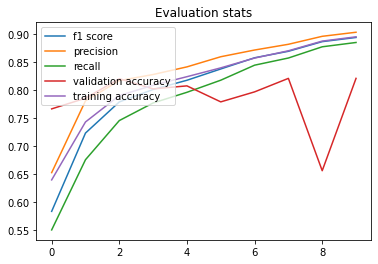

In [1]:
from __future__ import print_function
import os
from google.colab import drive
drive.mount("/content/drive",force_remount = True)
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error,accuracy_score
from keras.utils.vis_utils import plot_model
print('Indexing word vectors.')
import time
t1_emed_start = time.time()
MAX_SEQUENCE_LENGTH = 1000 #sequence length of the input vectors
MAX_NUM_WORDS = 20000 # Numbers of words that will be used to train the model
EMBEDDING_DIM = 100 #dimension of each of vector converted from each word
VALIDATION_SPLIT = 0.2 #validation size
TEST_SPLIT = 0.1 #test size
embeddings_index = {}
with open('/content/drive/My Drive/New_project/glove.txt') as f:  #location for glove embedding text file
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

df1=pd.read_csv("/content/drive/My Drive/New_project/hate.csv")  #input the data set fro hate
df1.text=df1.text.astype(str)
df2=pd.read_csv("/content/drive/My Drive/New_project/neither.csv") #input the data set for neutral
df2.text=df2.text.astype(str)
df3=pd.read_csv("/content/drive/My Drive/New_project/offensive.csv") #input the dataset for offensive
df3.text=df3.text.astype(str)
df=pd.concat([df1,df2,df3], axis=0) #merge the dataset together

print(len(df))
df=shuffle(df) # shuffle the dataset
print(df.head())

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []
review_df = df[['Annotation','text']]
# review_df = review_df.replace(to_replace ='[0-9]+', value = '', regex = True)
review_df = shuffle(review_df)
print("Here are Few Samples in data")
print(review_df.head())

print("Here total number of posistive, negative and unsupported (neutral) samples")
print(review_df.groupby(['Annotation']).count())

print("Converting pandas dataframe into lists") #Converting the data into pandas dataframe
texts = review_df['text'].values.tolist()
labels = []
labels_text = []
labels_text_unique = review_df.Annotation.unique().tolist() #extracting unique values and convert into a lsit
labels_text = review_df['Annotation'].values.tolist()
print(labels_text_unique)
idxCounter = 0
for label in labels_text_unique:
    labels_index[label] = idxCounter
    idxCounter = idxCounter + 1;

idxCounter = 0    
for label in labels_text:
    # print("processing row " + str(idxCounter))
    labels.append(labels_index[label])
    idxCounter = idxCounter + 1;
    

print("Labels Array")
print(len(labels))
print("Labels Dictionary")
print(labels_index)
print("type",type(labels_index))
print("Done")

def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# print(texts)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
print(indices)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
num_test_samples = int (TEST_SPLIT * data.shape[0])
x_train = data[:-num_validation_samples] # creation of train dataset
y_train = labels[:-num_validation_samples]
print("y_train",y_train)
print("type of y_train",type(y_train))
x_val = data[-num_validation_samples:] #creation of validation dataset
y_val = labels[-num_validation_samples:]
x_test = data[-num_test_samples:] #creation of test dataset
y_test = labels[-num_test_samples:]
print("length of train data", len(x_train))
print("length of validation data", len(x_val))
print("length of validation data", len(y_test))
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")
t1_emed_end = time.time()
print("embedding generation",t1_emed_end-t1_emed_start)
def recall_m(y_true, y_pred): #function to calculate the recall value
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred): #function to calculate the precision value
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred): #function to calculate the f1 value
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
t1_train_start = time.time()
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(512, 5, activation='relu')(embedded_sequences) #model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
x = Dropout(0.3)(x) #droupout layer to avoide overfitting
x = MaxPooling1D(5)(x) #maxpooling
x = Conv1D(512, 5, activation='relu')(x) #convolution layer
x = Dropout(0.2)(x) #dropout layer to avoide overfitting
x = MaxPooling1D(5)(x) #maxpooling layer
x = Conv1D(512, 5, activation='relu')(x) 
x = GlobalMaxPooling1D()(x)
x = Dense(512, activation='relu')(x) #dense layer
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', f1_m, precision_m, recall_m]) #parameters for model compilation
model.summary() #model summary
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
history = model.fit(x_train, y_train,
          batch_size=400, #400
          epochs=10, #3
          validation_data=(x_val, y_val))

pyplot.plot(history.history["f1_m"],  label="f1 score")   #plots of f1 score
pyplot.plot(history.history["precision_m"], label="precision")  #plots of precision
pyplot.plot(history.history["recall_m"], label="recall")  #plots of recall
pyplot.plot(history.history['val_acc'] , label="validation accuracy")  #plots of validation accuracy
pyplot.plot(history.history['acc'] , label="training accuracy")  #plots of training accuracy
pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")

t1_train_end = time.time()
print("training_time",t1_train_end-t1_train_start )
print("begin the test data")
t1_test_start = time.time()
y_pred = model.predict(x_test)
y_final = np.zeros_like(y_pred)
y_final[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
print("y_pred", y_final)
print("y_test", y_test)


f1_score = f1_m(y_test, y_final)
precision = precision_m(y_test, y_final)
recall= recall_m(y_test, y_final)
print("f1_score",f1_score)
print("precision",precision)
print("recall",recall)
test_texts = ["Who the fuck you callin jiggaboo, nigga!"]  # test tweet

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
nn_output = model.predict(test_data) #prediction of test tweet
print("nn_output",nn_output)
#nn_output = nn_output.shape[0]
nn_output_1 = np.zeros_like(nn_output)
nn_output_1[np.arange(len(nn_output)), nn_output.argmax(1)] = 1

print("nn_oputput",nn_output_1)
result = np.where(nn_output_1 == 1)
print("result",result)
print("type",type(result))
print("Labels Dictionary")
print(labels_index) #condition for classifying tweet as hateful, offensive and neutral
if result[1]==0:
    print("tweet is OFFENSIVE")
elif result[1]==1:
    print("tweet is HATE")
elif result[1]==2:
    print("tweet is NEUTRAL")
#Tweet_class = labels_index[result]
#print(Tweet_class)
#test tweet
i=0
for idx in np.argmax(nn_output, axis=1):
    print("text: " , test_texts[i])
    print("=====================================")
    i = i + 1
t1_test_end = time.time()
print("Total test time",(t1_test_end-t1_test_start))
pyplot.show()
f.close()
drive.flush_and_unmount()
